# Pre-processing

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 8.0 MB/s eta 0:00:00


In [ ]:
import torch

# PyTorch version
print("PyTorch version:", torch.__version__)

# CUDA version
print("CUDA version (build):", torch.version.cuda)


PyTorch version: 2.6.0+cu124
CUDA version (build): 12.4


In [ ]:
# 1) Install PyTorch with the CUDA 12.4 build (works on 12.5 drivers)
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu124

# 2) Install PyTorch-Geometric and its CUDA-dependent extensions
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch_geometric \
  -f https://data.pyg.org/whl/torch-2.4.0+cu124.html


In [ ]:
# Reproducibility: set random seed
import os
import random
import numpy as np
import torch

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

In [ ]:
import osmnx as ox
# Set the global configuration of OSMnx
ox.settings.log_console = True
ox.settings.use_cache    = True
ox.settings.data_folder  = os.path.join('/content/drive/MyDrive', 'Ruian_ERP', 'osmnx_cache')
# Create the result storage directory
base_path = '/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport2'
os.makedirs(base_path, exist_ok=True)


In [ ]:
print("CUDA:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

CUDA: True
Device: NVIDIA A100-SXM4-40GB


**Download and preprocess the Stockport road network**

In [ ]:
import osmnx as ox
import networkx as nx
# Download the driving network for Stockport
G_full = ox.graph_from_place("Stockport, UK", network_type="drive")

# Download the graph
graph_path = os.path.join(base_path, 'Stockport_graph.graphml')

if os.path.exists(graph_path):
     # 1. If already saved, read it directly
     G = ox.load_graphml(graph_path)
else:
     # 2. Otherwise, download, process and save it
     G = ox.graph_from_place('Stockport, Greater Manchester, UK', network_type='drive')
     G = ox.project_graph(G)
     isolated = list(nx.isolates(G))
     G.remove_nodes_from(isolated)
     ox.save_graphml(G, graph_path)

# 3. Convert to GeoDataFrames
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 4. Save nodes and edges to shapefile
nodes_shp = os.path.join(base_path, 'nodes.shp')
nodes_gdf.to_file(nodes_shp)
edges_shp = os.path.join(base_path, 'edges.shp')
edges_gdf.to_file(edges_shp)


/tmp/ipython-input-12-2040324823.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes_gdf.to_file(nodes_shp)
/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'street_count' to 'street_cou'
  ogr_write(


In [ ]:
# Check the coordinate reference system
print(nodes_gdf.crs, edges_gdf.crs)

EPSG:32630 EPSG:32630


# Feature construction

**Sanity check**

In [ ]:
!pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.2 MB/s eta 0:00:00


      osmid             y              x            highway   ref  street_cou  \
0    234966  5.917067e+06  552000.104922  motorway_junction     3           3   
1  15311937  5.916738e+06  551766.511679               None  None           3   
2  15316374  5.916882e+06  551300.226224  motorway_junction     4           3   
3    234967  5.917188e+06  552297.726137               None  None           3   
4    334001  5.916935e+06  550799.405422  motorway_junction     1           3   

  junction railway                        geometry  
0     None    None  POINT (552000.105 5917067.017)  
1     None    None  POINT (551766.512 5916738.316)  
2     None    None  POINT (551300.226 5916881.784)  
3     None    None  POINT (552297.726 5917187.834)  
4     None    None  POINT (550799.405 5916935.263)  


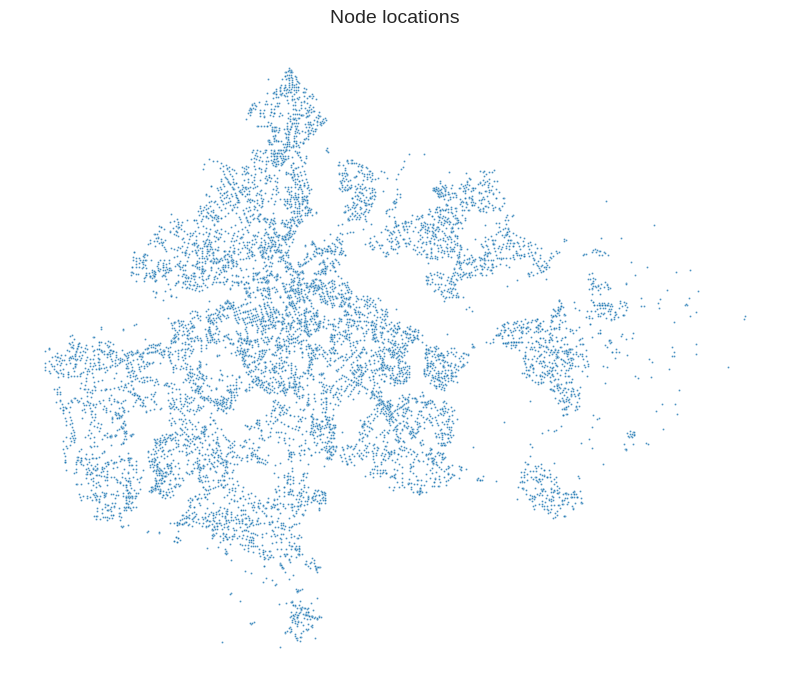

In [ ]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Parameter settings
plt.style.use('seaborn-v0_8-whitegrid')

POINT_SIZE       = 2
POINT_EDGEWIDTH  = 0.2
LINE_WIDTH       = 0.4
POINT_COLOR      = '#1f78b4'
LINE_COLOR       = '#555555'
ALPHA            = 0.8
BG_COLOR         = '#f5f5f5'
base_path = '/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport2'

# 2. Nodes visualisation
nodes = gpd.read_file(os.path.join(base_path, 'nodes.shp'))
print(nodes.head())

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor(BG_COLOR)

nodes.plot(
    ax=ax,
    markersize=POINT_SIZE,
    color=POINT_COLOR,
    edgecolor='white',
    linewidth=POINT_EDGEWIDTH,
    alpha=ALPHA,
    zorder=2
)

ax.set_title("Node locations", fontsize=14, pad=12)
ax.set_axis_off()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


          u         v  key                                      osmid  \
0    234966  15311937    0  [4966857, 30631403, 1128685924, 30631406]   
1    234966  15316374    0            [30631490, 135848931, 30631502]   
2  15311937  15311946    0                      [4972168, 1128685925]   
3  15316374  15312006    0                                    4966822   
4  15316374    334547    0                                  979363523   

         highway       lanes              maxspeed  oneway  ref reversed  \
0  motorway_link           2  ['70 mph', '40 mph']    True  M60    False   
1       motorway           4                70 mph    True  M60    False   
2  motorway_link  ['2', '3']                40 mph    True  M60    False   
3       motorway           2                70 mph    True  M56    False   
4       motorway           3                70 mph    True  M60    False   

       length bridge  name junction access tunnel width  area  \
0  439.860261   None  None     None   N

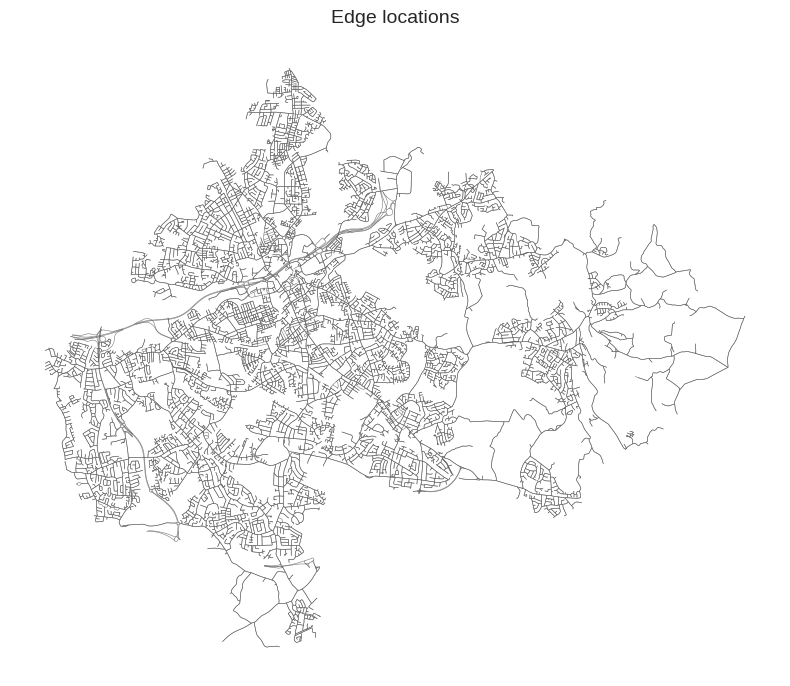

In [ ]:
# 3. Edge visualisation
edges = gpd.read_file(os.path.join(base_path, 'edges.shp'))
print(edges.head())

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor(BG_COLOR)

edges.plot(
    ax=ax,
    linewidth=LINE_WIDTH,
    edgecolor=LINE_COLOR,
    alpha=ALPHA,
    zorder=1
)

ax.set_title("Edge locations", fontsize=14, pad=12)
ax.set_axis_off()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


In [ ]:
print(edges['highway'].unique())

['motorway_link' 'motorway' 'trunk' 'primary'
 "['trunk_link', 'motorway_link']" 'residential' 'unclassified'
 'secondary' 'primary_link' 'trunk_link' 'tertiary_link' 'tertiary'
 'secondary_link' "['residential', 'unclassified']"
 "['primary', 'unclassified']" 'living_street'
 "['living_street', 'residential', 'unclassified']"
 "['living_street', 'residential']" 'road'
 "['living_street', 'unclassified']"]


## Feature extraction & preprocessing

**Collect original node/edge features**

In [ ]:
import osmnx as ox
import networkx as nx
import pandas as pd
import numpy as np

# 1. Load the main image of the entire city
graphml_path = os.path.join(base_path, "Stockport_graph.graphml")
G = ox.load_graphml(graphml_path)

# 2. Convert to geoDataframes for nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# 3. Node feature DataFrame
node_records = []

for node_id, row in nodes_gdf.iterrows():
    node_records.append({
        'node': node_id,
        'x': row.geometry.x,
        'y': row.geometry.y,
        'degree': G.degree(node_id),
        #'highway': row.get('highway', 'unclassified')
    })
nodes_df = pd.DataFrame(node_records)

# 4. Edge feature DataFrame
edge_records = []
for u, v, data in G.edges(data=True):
    edge_records.append({
        'u': u, 'v': v,
        'length': data.get('length', np.nan),
        'maxspeed': data.get('maxspeed', np.nan),
        'lanes': data.get('lanes', np.nan),
        'highway': data.get('highway', 'unclassified')
    })
edges_df = pd.DataFrame(edge_records)




---

### Edges operations:

In [ ]:
edges_df

,u,v,length,maxspeed,lanes,highway
0,234966,15311937,439.860261,"[70 mph, 40 mph]",2,motorway_link
1,234966,15316374,723.418337,70 mph,4,motorway
2,15311937,15311946,290.487638,40 mph,"[3, 2]",motorway_link
3,15316374,15312006,447.476989,70 mph,2,motorway
4,15316374,334547,543.723844,70 mph,3,motorway
...,...,...,...,...,...,...
22405,12947145063,12947145062,10.148451,NaN,NaN,residential
22406,12947145063,12595404702,94.040217,NaN,NaN,residential
22407,12947145063,12962058683,40.867844,NaN,NaN,residential
22408,12947145062,12947145063,10.148451,NaN,NaN,residential


In [ ]:
# Count the missing situations of each field
print(edges_df[['length', 'maxspeed', 'lanes', 'highway']].isna().sum())
# Highway Type Distribution
print(edges_df['highway'].value_counts())
# Descriptive statistics of length
print(edges_df['length'].describe())


length          0
maxspeed     8975
lanes       20825
highway         0
dtype: int64
highway
residential                                   17716
primary                                        1313
tertiary                                       1042
secondary                                       835
unclassified                                    749
trunk                                           513
trunk_link                                       40
tertiary_link                                    34
living_street                                    30
[residential, unclassified]                      24
[unclassified, residential]                      24
primary_link                                     21
motorway                                         20
motorway_link                                    17
secondary_link                                   10
[living_street, residential]                      6
[trunk_link, motorway_link]                       4
[residential, living_st

In [ ]:
import os
import re
import ast
import numpy as np
import pandas as pd
import geopandas as gpd

# ─── 1) NORMALIZE 'highway' COLUMN ─────────────────────────────────────────────
def normalize_highway(hw):
    """
    1) If hw is a real list or tuple, return its first element.
    2) If hw is a string representation of a list (e.g. "['a','b']"),
       parse it with ast.literal_eval and take the first element.
    3) If hw is NaN, None, or an empty string, return 'unclassified'.
    4) Otherwise, return hw unchanged.
    """
    # Case 1: real list or tuple
    if isinstance(hw, (list, tuple)) and hw:
        return hw[0]
    # Case 2: string that looks like a list
    if isinstance(hw, str) and hw.startswith('[') and hw.endswith(']'):
        try:
            lst = ast.literal_eval(hw)
            if isinstance(lst, (list, tuple)) and lst:
                return lst[0]
        except Exception:
            pass
    # Case 3: missing or empty
    if pd.isna(hw) or hw is None or hw == '':
        return 'unclassified'
    # Case 4: already a single tag
    return hw

edges_df['highway'] = edges_df['highway'].apply(normalize_highway)

# ─── 2) ENSURE 'length' & 'lanes' ARE NUMERIC ─────────────────────────────────
def take_first(x):
    if isinstance(x, (list, tuple)) and x:
        return x[0]
    return x

edges_df['length'] = pd.to_numeric(
    edges_df['length'].apply(take_first),
    errors='coerce'
)
edges_df['lanes'] = pd.to_numeric(
    edges_df['lanes'].apply(take_first),
    errors='coerce'
)

# ─── 3) PARSE & CONVERT 'maxspeed' → km/h ───────────────────────────────────────
def parse_maxspeed(val):
    m = re.match(r'(\d+(\.\d+)?)', str(val))
    if not m:
        return np.nan
    speed = float(m.group(1))
    return speed * 1.60934 if 'mph' in str(val).lower() else speed

edges_df['maxspeed_kmh'] = edges_df['maxspeed'].apply(parse_maxspeed)

# ─── 4) COMPUTE GROUP‐WISE STATISTICS ───────────────────────────────────────────
grp = edges_df.groupby('highway')

# medians for length and maxspeed
med_length = grp['length'].median()
med_speed  = grp['maxspeed_kmh'].median()

# modes for lanes (take the first mode, fallback to 1 if none)
mode_lanes = grp['lanes'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else 1)

# global fallbacks
global_length = edges_df['length'].median()
global_speed  = edges_df['maxspeed_kmh'].median()
global_lanes  = int(edges_df['lanes'].mode().iat[0])  # most common lane count

# ─── 5) IMPUTE MISSING VALUES ───────────────────────────────────────────────────
# length: group‐wise median → global median
edges_df['length'] = edges_df.apply(
    lambda r: med_length[r['highway']] if pd.isna(r['length']) else r['length'],
    axis=1
).fillna(global_length).astype(float)

# maxspeed: group‐wise median → global median
edges_df['maxspeed_kmh'] = edges_df.apply(
    lambda r: med_speed[r['highway']] if pd.isna(r['maxspeed_kmh']) else r['maxspeed_kmh'],
    axis=1
).fillna(global_speed).astype(float)

# lanes: group‐wise mode → global mode, then round & int
edges_df['lanes'] = edges_df.apply(
    lambda r: mode_lanes[r['highway']] if pd.isna(r['lanes']) else r['lanes'],
    axis=1
).fillna(global_lanes).round().astype(int)

# ─── 6) RESULT SUMMARY ─────────────────────────────────────────────────────────
print("Unique lane counts after imputation:", edges_df['lanes'].unique())
print("Lane value counts:\n", edges_df['lanes'].value_counts())


Unique lane counts after imputation: [2 4 3 1 5 6]
Lane value counts:
 lanes
2    21174
1     1008
3      101
4      100
5       20
6        7
Name: count, dtype: int64


In [ ]:
# ─── 6.1) MAP TO ROAD LEVEL (1–8) ───────────────────────────────────────────────
road_level_map = {
    'motorway':1,'motorway_link':1,
    'trunk':2,'trunk_link':2,
    'primary':3,'primary_link':3,
    'secondary':4,'secondary_link':4,
    'tertiary':5,'tertiary_link':5,
    'residential':6,'living_street':6,'unclassified':6,'road':6,
    'busway':7,'service':7,'track':7,
    'footway':8,'pedestrian':8,'cycleway':8
}
edges_df['road_level'] = edges_df['highway'].map(road_level_map).fillna(6).astype(int)

# ─── 6.2) ONE-HOT ENCODE ROAD LEVEL ─────────────────────────────────────────────
from sklearn.preprocessing import OneHotEncoder

# define categories 1–8 in order
levels = list(range(1,9))
ohe = OneHotEncoder(categories=[levels], sparse_output=False, handle_unknown='ignore')
onehot = ohe.fit_transform(edges_df[['road_level']])

# build column names and concat back
oh_cols = [f"level_{lvl}" for lvl in levels]
oh_df = pd.DataFrame(onehot, columns=oh_cols, index=edges_df.index)
edges_df = pd.concat([edges_df, oh_df], axis=1)


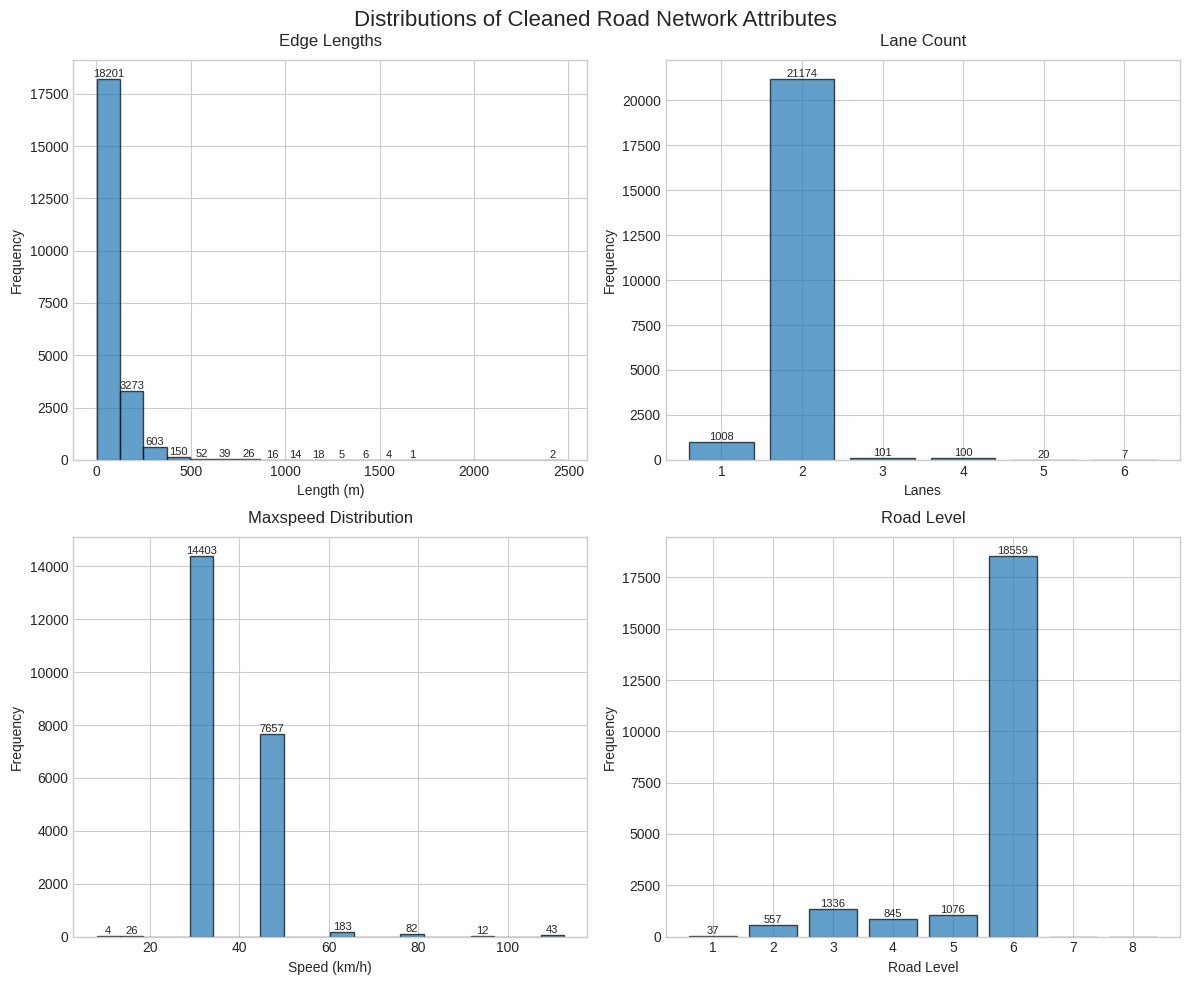

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# helper to annotate bars
def annotate_bars(ax, fmt="{:.0f}"):
    for bar in ax.patches:
        height = bar.get_height()
        if height > 0:  # only annotate bars with positive height
            ax.text(
                bar.get_x() + bar.get_width() / 2,  # x position: center of bar
                height,                             # y position: top of bar
                fmt.format(height),                 # text
                ha='center', va='bottom', fontsize=8
            )

# 1. Edge Lengths
axes[0].hist(edges_df['length'], bins=20, edgecolor='black', alpha=0.7)
axes[0].set_title("Edge Lengths", fontsize=12, pad=10)
axes[0].set_xlabel("Length (m)", fontsize=10)
axes[0].set_ylabel("Frequency", fontsize=10)
annotate_bars(axes[0])

# 2. Lane Count
axes[1].hist(
    edges_df['lanes'].dropna(),
    bins=range(1, edges_df['lanes'].max() + 2),
    align='left', rwidth=0.8,
    edgecolor='black', alpha=0.7
)
axes[1].set_title("Lane Count", fontsize=12, pad=10)
axes[1].set_xlabel("Lanes", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)
axes[1].set_xticks(range(1, edges_df['lanes'].max() + 1))
annotate_bars(axes[1], fmt="{:.0f}")

# 3. Maxspeed Distribution
axes[2].hist(
    edges_df['maxspeed_kmh'].dropna(),
    bins=20, edgecolor='black', alpha=0.7
)
axes[2].set_title("Maxspeed Distribution", fontsize=12, pad=10)
axes[2].set_xlabel("Speed (km/h)", fontsize=10)
axes[2].set_ylabel("Frequency", fontsize=10)
annotate_bars(axes[2])

# 4. Road Level
axes[3].hist(
    edges_df['road_level'],
    bins=range(1, 10), align='left', rwidth=0.8,
    edgecolor='black', alpha=0.7
)
axes[3].set_title("Road Level", fontsize=12, pad=10)
axes[3].set_xlabel("Road Level", fontsize=10)
axes[3].set_ylabel("Frequency", fontsize=10)
axes[3].set_xticks(range(1, 9))
annotate_bars(axes[3], fmt="{:.0f}")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
fig.suptitle("Distributions of Cleaned Road Network Attributes", fontsize=16)
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# pick the numeric edge cols:
edge_num_cols = ['length','maxspeed_kmh','lanes']
# scale them (or reuse your pre-fit scaler)
edge_scaler = StandardScaler().fit(edges_df[edge_num_cols])
edges_num = edge_scaler.transform(edges_df[edge_num_cols].values)

# pick the one-hot cols for edges
oh_cols = [f'level_{i}' for i in range(1,9)]
edges_cat = edges_df[oh_cols].values

#——————————————————————————————————————————————————————————
# Create a node_id map of all occurrences of node ids
# to integer numbers from 0 to N-1
all_node_ids = pd.unique(edges_df[['u', 'v']].values.ravel())
node_id_map = {nid: i for i, nid in enumerate(all_node_ids)}

# Replace u and v of edges_df with new numbers
edges_df['u_idx'] = edges_df['u'].map(node_id_map)
edges_df['v_idx'] = edges_df['v'].map(node_id_map)

# Only the numbered columns are kept
edge_cols = [
    'u_idx', 'v_idx',
    'u','v',
    'length', 'maxspeed_kmh', 'lanes'
] + [f'level_{i}' for i in range(1, 9)]

edges_df = edges_df[edge_cols]
#——————————————————————————————————————————————————————————

# stack into an (E, 3 + 8) matrix
X_edges = np.hstack([edges_num, edges_cat])
print("X_edges shape:", X_edges.shape)


X_edges shape: (22410, 11)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# Save the numpy feature matrix and scaler
import pickle

np.save(os.path.join(base_path, 'X_edges.npy'), X_edges)

with open(os.path.join(base_path, 'edge_scaler.pkl'), 'wb') as f:
    pickle.dump(edge_scaler, f)

edges_df.to_csv(os.path.join(base_path, 'edges_processed.csv'), index=False)


In [ ]:
# Extract the numbered u_idx and v_idx columns
edge_pairs = edges_df[['u_idx', 'v_idx']].drop_duplicates().values

# Extend to undirected edges (once for undirected graphs /NetGAN)
edge_pairs_bidirect = np.vstack([edge_pairs, edge_pairs[:, ::-1]])

# Convert to PyG format [2, num_edges]
edge_index = edge_pairs_bidirect.T    # shape: (2, num_edges)

# Save as.npy
np.save(os.path.join(base_path, 'edge_index.npy'), edge_index)
print('Saved edge_index.npy, shape:', edge_index.shape)

Saved edge_index.npy, shape: (2, 44450)


In [ ]:
edges_df

,u_idx,v_idx,u,v,length,maxspeed_kmh,lanes,level_1,level_2,level_3,level_4,level_5,level_6,level_7,level_8
0,0,1,234966,15311937,439.860261,112.6538,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,234966,15316374,723.418337,112.6538,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,15311937,15311946,290.487638,64.3736,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,4,15316374,15312006,447.476989,112.6538,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,5,15316374,334547,543.723844,112.6538,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22405,9969,9970,12947145063,12947145062,10.148451,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22406,9969,9964,12947145063,12595404702,94.040217,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22407,9969,9971,12947145063,12962058683,40.867844,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
22408,9970,9969,12947145062,12947145063,10.148451,32.1868,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
X_edges

array([[ 3.49386339,  8.15260281,  0.09205823, ...,  0.        ,
         0.        ,  0.        ],
       [ 6.30050588,  8.15260281,  7.23055263, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.01538125,  2.86033038,  3.66130543, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.45534196, -0.66785125,  0.09205823, ...,  1.        ,
         0.        ,  0.        ],
       [-0.75940085, -0.66785125,  0.09205823, ...,  1.        ,
         0.        ,  0.        ],
       [-0.45534196, -0.66785125,  0.09205823, ...,  1.        ,
         0.        ,  0.        ]])

**Sanity Check**

In [ ]:
print(edges_df.columns)

Index(['u_idx', 'v_idx', 'length', 'maxspeed_kmh', 'lanes', 'level_1',
       'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7',
       'level_8'],
      dtype='object')


In [ ]:
# List the columns you care about
cols = ['length', 'maxspeed_kmh', 'lanes']

for col in cols:
    print(f"── {col} ──")
    # All unique values
    print(edges_df[col].unique())
    # How many times each value has appeared：
    print(edges_df[col].value_counts(dropna=False).head(10))
    print()


── length ──
[439.86026066 723.4183371  290.48763753 ...  10.14845148  94.0402166
  40.86784448]
length
64.164915     2
40.867844     2
5.755019      2
76.903585     2
44.345208     2
102.813088    2
102.068179    2
10.045206     2
58.989853     2
87.068355     2
Name: count, dtype: int64

── maxspeed_kmh ──
[112.6538  64.3736  48.2802  80.467   32.1868  16.0934   8.0467  96.5604]
maxspeed_kmh
32.1868     14419
48.2802      7641
64.3736       183
80.4670        82
112.6538       43
16.0934        26
96.5604        12
8.0467          4
Name: count, dtype: int64

── lanes ──
[2 4 3 1 5 6]
lanes
2    21162
1      989
3      138
4       94
5       23
6        4
Name: count, dtype: int64





---

### Nodes operations:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#——————————————————————————————————————————————————————————
# Create a node_id map of all occurrences of node ids
# to integer numbers from 0 to N-1
# Replace edges_df's node with the new number
nodes_df['node_idx'] = nodes_df['node'].map(node_id_map)

# Keep only the fields you want
node_cols = [
    'node_idx', 'x', 'y', 'degree']
nodes_df = nodes_df[node_cols]
#——————————————————————————————————————————————————————————

# 4) Standardise numeric node columns
num_node_cols = ['x','y','degree']
node_scaler  = StandardScaler().fit(nodes_df[num_node_cols].values)
nodes_scaled = node_scaler.transform(nodes_df[num_node_cols].values)

# 5) Stack into final node feature matrix
X_nodes = nodes_scaled
print("X_nodes shape:", X_nodes.shape)  # (n_nodes, 3)


X_nodes shape: (9972, 3)


In [ ]:
# Save
X_nodes = nodes_scaled
np.save(os.path.join(base_path, 'X_nodes.npy'), X_nodes)

with open(os.path.join(base_path, 'node_scaler.pkl'), 'wb') as f:
    pickle.dump(node_scaler, f)

nodes_df.to_csv(os.path.join(base_path, 'nodes_processed.csv'), index=False)


In [ ]:
nodes_df

,node_idx,x,y,degree
0,0,552000.104922,5.917067e+06,3
1,1,551766.511679,5.916738e+06,2
2,2,551300.226224,5.916882e+06,3
3,6,552297.726137,5.917188e+06,3
4,7,550799.405422,5.916935e+06,2
...,...,...,...,...
9967,9963,556172.154438,5.909859e+06,6
9968,9964,556147.490210,5.909864e+06,6
9969,9969,556060.048640,5.909841e+06,6
9970,9970,556050.174652,5.909838e+06,2


# CGAN Model

## Model training

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import autograd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import ks_2samp
import pickle

# ─────────────────────────────────────────────────────────────────────────────
# 1) Load & preprocess with log‐transform for skewed features
# ─────────────────────────────────────────────────────────────────────────────

base_path = '/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport'
nodes_df  = pd.read_csv(os.path.join(base_path, 'nodes_processed.csv'))
edges_df  = pd.read_csv(os.path.join(base_path, 'edges_processed.csv'))

# Apply log1p to skewed continuous columns
edges_df['length_log']      = np.log1p(edges_df['length'])
edges_df['speed_log']       = np.log1p(edges_df['maxspeed_kmh'])
cont_cols = ['length_log', 'speed_log', 'lanes']
cont_dim  = len(cont_cols)

# One-hot condition columns unchanged
cond_cols = [f'level_{i}' for i in range(1,9)]
cond_dim  = len(cond_cols)

# Build arrays for training
X_cont       = edges_df[cont_cols].values.astype(np.float32)
X_cond       = edges_df[cond_cols].values.astype(np.float32)

# Fit scaler on the log-transformed continuous features
scaler       = StandardScaler()
X_cont_norm  = scaler.fit_transform(X_cont)

# Save scaler for later inverse
with open(os.path.join(base_path, 'scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 2) Dataset & DataLoader
# ─────────────────────────────────────────────────────────────────────────────
class EdgeAttrDataset(Dataset):
    def __init__(self, cont, cond):
        self.cont = torch.from_numpy(cont)
        self.cond = torch.from_numpy(cond)
    def __len__(self):
        return len(self.cont)
    def __getitem__(self, idx):
        return self.cont[idx], self.cond[idx]

dataset = EdgeAttrDataset(X_cont_norm, X_cond)
loader  = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=True)

# ─────────────────────────────────────────────────────────────────────────────
# 3) Define WGAN-GP Generator & Critic
# ─────────────────────────────────────────────────────────────────────────────
noise_dim = 16
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Generator(nn.Module):
    def __init__(self, noise_dim, cond_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim + cond_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, out_dim),
        )
    def forward(self, z, cond):
        x = torch.cat([z, cond], dim=1)
        return self.net(x)

from torch.nn.utils import spectral_norm
class Critic(nn.Module):
    def __init__(self, in_dim, cond_dim):
        super().__init__()
        self.net = nn.Sequential(
            spectral_norm(nn.Linear(in_dim + cond_dim, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(256, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(512, 128)),
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(128, 1)),
        )
    def forward(self, x, cond):
        h = torch.cat([x, cond], dim=1)
        return self.net(h)

def gradient_penalty(critic, real, fake, cond, λ, device):
    B = real.size(0)
    α = torch.rand(B, 1, device=device).expand_as(real)
    inter = (α * real + (1 - α) * fake).requires_grad_(True)
    out = critic(inter, cond)
    grads = autograd.grad(
        outputs=out, inputs=inter,
        grad_outputs=torch.ones_like(out),
        create_graph=True, retain_graph=True
    )[0]
    norm = grads.view(B, -1).norm(2, dim=1)
    return λ * ((norm - 1) ** 2).mean()

G = Generator(noise_dim, cond_dim, cont_dim).to(device)
C = Critic(cont_dim, cond_dim).to(device)
g_opt = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
c_opt = optim.Adam(C.parameters(), lr=1e-4, betas=(0.5, 0.9))


In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
# 4) Train WGAN-GP (with proper epoch-level loss accumulation)
# ─────────────────────────────────────────────────────────────────────────────
epochs    = 200
n_critic  = 3
λ_gp      = 10

critic_losses = []
gen_losses    = []

for epoch in range(1, epochs+1):
    # 1) initialize accumulators
    c_loss_epoch = 0.0
    g_loss_epoch = 0.0

    for real_x, cond in loader:
        real_x = real_x.to(device)
        cond   = cond.to(device)
        B      = real_x.size(0)

        # 2) Critic updates
        for _ in range(n_critic):
            z      = torch.randn(B, noise_dim, device=device)
            fake_x = G(z, cond).detach()
            r_score= C(real_x, cond)
            f_score= C(fake_x, cond)
            gp     = gradient_penalty(C, real_x, fake_x, cond, λ_gp, device)
            c_loss = f_score.mean() - r_score.mean() + gp

            c_opt.zero_grad()
            c_loss.backward()
            c_opt.step()

            # 3) Accumulate critic loss
            c_loss_epoch += c_loss.item()

        # 4) Generator update
        z      = torch.randn(B, noise_dim, device=device)
        fake_x = G(z, cond)
        g_loss = -C(fake_x, cond).mean()

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

        # 5) Accumulate generator loss
        g_loss_epoch += g_loss.item()

    # 6) Compute epoch‐average losses
    avg_c = c_loss_epoch / (len(loader) * n_critic)
    avg_g = g_loss_epoch / len(loader)
    critic_losses.append(avg_c)
    gen_losses.append(avg_g)

    # 7) Logging
    if epoch == 1 or epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}  Critic: {avg_c:.4f}  Gen: {avg_g:.4f}")

# ─────────────────────────────────────────────────────────────────────────────
# 8) Save models
# ─────────────────────────────────────────────────────────────────────────────
torch.save(G.state_dict(), os.path.join(base_path, 'generator.pth'))
torch.save(C.state_dict(), os.path.join(base_path, 'critic.pth'))


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/200  Critic: 6.2408  Gen: -0.6958
Epoch 10/200  Critic: -0.7565  Gen: 2.5855
Epoch 20/200  Critic: 1.3368  Gen: 0.9282
Epoch 30/200  Critic: 2.8426  Gen: -0.2219
Epoch 40/200  Critic: 1.8565  Gen: -0.2488
Epoch 50/200  Critic: -0.1335  Gen: 0.1700
Epoch 60/200  Critic: -0.0635  Gen: 0.3166
Epoch 70/200  Critic: -0.0412  Gen: 0.0673
Epoch 80/200  Critic: -0.0125  Gen: -0.0308
Epoch 90/200  Critic: -0.0079  Gen: 0.0493
Epoch 100/200  Critic: 0.0386  Gen: 0.0291
Epoch 110/200  Critic: 0.0343  Gen: -0.1206
Epoch 120/200  Critic: 0.0005  Gen: -0.0463
Epoch 130/200  Critic: 0.1040  Gen: 0.1752
Epoch 140/200  Critic: 0.1809  Gen: 0.1261
Epoch 150/200  Critic: 0.1395  Gen: -0.0618
Epoch 160/200  Critic: 0.2093  Gen: -0.0381
Epoch 170/200  Critic: 0.0232  Gen: 0.0128
Epoch 180/200  Critic: 0.1549  Gen: -0.5064
Epoch 190/200  Critic: 0.0739  Gen: -0.0612
Epoch 200/200  Critic: 0.0567  Gen: 0.0026


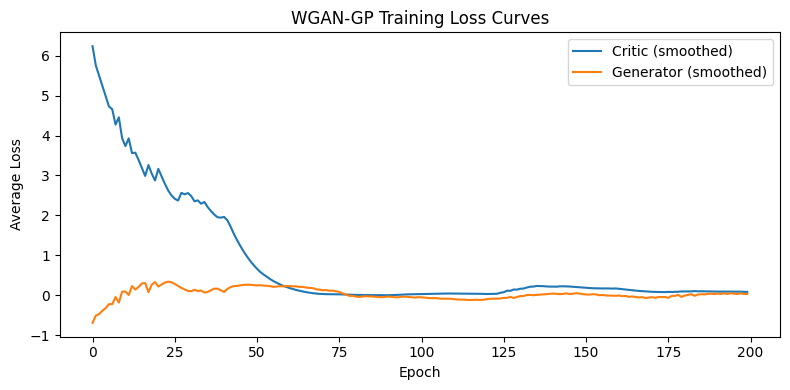

In [ ]:
# ─── Plot training loss curves ────────────────────────────────────────────────
import matplotlib.pyplot as plt

def smooth(losses, decay=0.9):
    sm = []
    v = losses[0]
    for x in losses:
        v = decay*v + (1 - decay)*x
        sm.append(v)
    return sm

# smooth the epoch-level loss lists
smoothed_C = smooth(critic_losses)
smoothed_G = smooth(gen_losses)

plt.figure(figsize=(8,4))
plt.plot(smoothed_C, label='Critic (smoothed)')
plt.plot(smoothed_G, label='Generator (smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss Curves')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Reload saved files
import os
import pickle
import torch
import pandas as pd
import numpy as np

# 1) Paths
base_path      = '/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport'
gen_path       = os.path.join(base_path, 'generator.pth')
critic_path    = os.path.join(base_path, 'critic.pth')
scaler_path    = os.path.join(base_path, 'scaler.pkl')
edges_csv      = os.path.join(base_path, 'edges_processed.csv')
nodes_csv      = os.path.join(base_path, 'nodes_processed.csv')

# 2) Reload data + scaler
edges_df   = pd.read_csv(edges_csv)
nodes_df   = pd.read_csv(nodes_csv)
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

# 3) Re-instantiate the models exactly as in training
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_dim = 16
cont_cols = ['length_log','speed_log','lanes']       # same order as training
cond_cols = [f'level_{i}' for i in range(1,9)]
cont_dim  = len(cont_cols)
cond_dim  = len(cond_cols)

# 4) Rebuild the conditioning array X_cond
X_cond = edges_df[cond_cols].values.astype(np.float32)


Mounted at /content/drive


In [ ]:
# 5) Generate synthetic continuous features and inverse-transform
G.eval()
conds_all = torch.from_numpy(X_cond).to(device)
N         = conds_all.size(0)

with torch.no_grad():
    z_all    = torch.randn(N, noise_dim, device=device)
    fake_cn  = G(z_all, conds_all).cpu().numpy()

# Inverse-scale from normalized log-space back to log values
cont_synth_log = scaler.inverse_transform(fake_cn)

# Undo log1p → original scale
length_syn = np.expm1(cont_synth_log[:, 0])
speed_syn  = np.expm1(cont_synth_log[:, 1])
lanes_syn  = cont_synth_log[:, 2]

# Build synthetic DataFrame (preliminarily)
synthetic_df = edges_df[cond_cols].copy()
synthetic_df['length']       = length_syn
synthetic_df['maxspeed_kmh'] = speed_syn
synthetic_df['lanes']        = lanes_syn

# ─── 5.1) Post-process lanes: round to nearest integer and clip to valid range ───
min_lane = int(edges_df['lanes'].min())
max_lane = int(edges_df['lanes'].max())
lanes_int = np.clip(np.rint(synthetic_df['lanes']), min_lane, max_lane).astype(int)
synthetic_df['lanes'] = lanes_int

# ─── 5.2) Post-process speed: snap to nearest observed speed bin ─────────────────
# compute the unique, sorted speed bins from real data
speed_bins = np.sort(edges_df['maxspeed_kmh'].unique().astype(int))

def snap_speed(val, bins):
    # find the bin whose distance to val is minimal
    idx = np.abs(bins - val).argmin()
    return bins[idx]

# apply snapping to each synthetic speed
synthetic_df['maxspeed_kmh'] = [
    snap_speed(v, speed_bins) for v in synthetic_df['maxspeed_kmh']
]

# ─── 5.3) Post-process length: quantile mapping to restore heavy tail ────────────
from scipy.stats import percentileofscore
from sklearn.isotonic import IsotonicRegression

# fit empirical quantiles of real length
real_vals = edges_df['length'].values
qs = np.linspace(0, 1, 1001)
real_q = np.quantile(real_vals, qs)

# train isotonic regressor: from quantile level → real length
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(qs, real_q)

# compute quantile of each synthetic length against real distribution
syn_q = np.array([percentileofscore(real_vals, v) / 100 for v in length_syn])
mapped_length = iso.predict(syn_q)
synthetic_df['length'] = mapped_length

# ─── 6) Merge coordinates and save ────────────────────────────────────────────────
synthetic_df['u_idx'] = edges_df['u_idx']
synthetic_df['v_idx'] = edges_df['v_idx']
synthetic_df = synthetic_df.merge(
    nodes_df.rename(columns={'node_idx':'u_idx','x':'u_x','y':'u_y'}),
    on='u_idx'
).merge(
    nodes_df.rename(columns={'node_idx':'v_idx','x':'v_x','y':'v_y'}),
    on='v_idx'
)

out_csv = os.path.join(base_path, 'synthetic_edge_attributes_2.csv')
synthetic_df.to_csv(out_csv, index=False)
print("Saved synthetic edge attributes to", out_csv)


Saved synthetic edge attributes to /content/drive/MyDrive/Ruian_ERP/road_networks/Stockport/synthetic_edge_attributes_2.csv


## Metrics evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

base_path = '/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport'
csv_path = '/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport/synthetic_edge_attributes_2.csv'
synthetic_df = pd.read_csv(csv_path)
edges_df = pd.read_csv(os.path.join(base_path, 'edges_processed.csv'))


# Quick check
print(synthetic_df.shape)
print(synthetic_df.head())


Mounted at /content/drive
(22410, 19)
   level_1  level_2  level_3  level_4  level_5  level_6  level_7  level_8  \
0      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

       length  maxspeed_kmh  lanes  u_idx  v_idx            u_x           u_y  \
0  119.504664            32      2      0      1  552000.104922  5.917067e+06   
1   68.515526            48      2      0      2  552000.104922  5.917067e+06   
2   33.731958            64      2      1      3  551766.511679  5.916738e+06   
3  152.681621            32      2      2      4  551300.226224  5.916882e+06   
4   56.385444            32      2      2      5  551300.226224  5.916882e+06   

   degree_x 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.stats import wasserstein_distance

# --- Inputs: post-processed DataFrames 'edges_df' (real) and 'synthetic_df' (synthetic) ---
# Continuous features for W1 (pre-binning speed)
cont_cols = ['length', 'maxspeed_kmh']  # use continuous speed for W1
# Categorical features for TVD (post-binning speed + integer lanes)
cat_cols  = ['maxspeed_kmh', 'lanes']   # ensure these are discrete for TVD
# Conditional one-hot road levels
cond_cols = [f'level_{i}' for i in range(1, 9)]

# ---------------- 1) pMSE (propensity score utility) ----------------
# Build a combined dataset with the same feature schema
real = edges_df[cont_cols + cond_cols].copy()
real['is_syn'] = 0
fake = synthetic_df[cont_cols + cond_cols].copy()
fake['is_syn'] = 1
combo = pd.concat([real, fake], ignore_index=True).dropna()

# Train/test split for the propensity model
X = combo[cont_cols + cond_cols].values
y = combo['is_syn'].values
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Regularized logistic regression as a propensity classifier
clf = LogisticRegression(max_iter=2000)
clf.fit(X_tr, y_tr)

# Predicted synthetic probability on the test set
p_hat = clf.predict_proba(X_te)[:, 1]

# pMSE (raw only)
c = y_te.mean()                     # proportion synthetic in test
N = len(y_te)                       # test size
pMSE = np.mean((p_hat - c) ** 2)    # smaller is better

print(f"[pMSE] raw={pMSE:.6f}  (c={c:.3f}, N={N})")

# ---------------- 2) W1 for continuous attributes ----------------
# Compute 1-Wasserstein distance for continuous variables
for col in cont_cols:
    r = edges_df[col].dropna().values
    s = synthetic_df[col].dropna().values
    w1 = wasserstein_distance(r, s)
    print(f"[W1 ] {col:12s} = {w1:.4f}")

# ---------------- 3) TVD for discrete/categorical attributes ----------------
def tvd_counts(a, b):
    """
    Total Variation Distance between two categorical distributions given samples a and b.
    """
    va, ca = np.unique(a, return_counts=True)
    vb, cb = np.unique(b, return_counts=True)
    vals = np.union1d(va, vb)
    pa = np.array([ca[va == v][0] if v in va else 0 for v in vals], dtype=float)
    pb = np.array([cb[vb == v][0] if v in vb else 0 for v in vals], dtype=float)
    pa /= pa.sum()
    pb /= pb.sum()
    return 0.5 * np.abs(pa - pb).sum()

# Overall TVD and stratified TVD by road level
for col in cat_cols:
    # Cast to int for discrete comparison (ensure bins/lanes are integers)
    tvd_all = tvd_counts(edges_df[col].astype(int).values,
                         synthetic_df[col].astype(int).values)
    print(f"[TVD] {col:12s} overall = {tvd_all:.4f}")

    # Per-road-level stratification (skip very small strata)
    for L in range(1, 9):
        idx_r = edges_df[cond_cols[L - 1]] == 1
        idx_s = synthetic_df[cond_cols[L - 1]] == 1
        if idx_r.sum() < 20 or idx_s.sum() < 20:
            continue
        tvd_L = tvd_counts(edges_df.loc[idx_r, col].astype(int).values,
                           synthetic_df.loc[idx_s, col].astype(int).values)
        print(f"        level {L}: TVD={tvd_L:.4f}")


[pMSE] raw=0.013934  (c=0.500, N=13446)
[W1 ] length       = 34.1945
[W1 ] maxspeed_kmh = 2.1901
[TVD] maxspeed_kmh overall = 0.0753
        level 1: TVD=0.9189
        level 2: TVD=0.6194
        level 3: TVD=0.5449
        level 4: TVD=0.5964
        level 5: TVD=0.5223
        level 6: TVD=0.1641
[TVD] lanes        overall = 0.0539
        level 1: TVD=0.8108
        level 2: TVD=0.2890
        level 3: TVD=0.0801
        level 4: TVD=0.0497
        level 5: TVD=0.0641
        level 6: TVD=0.0440


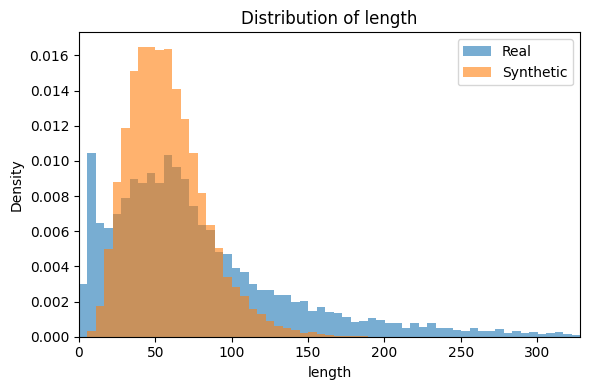

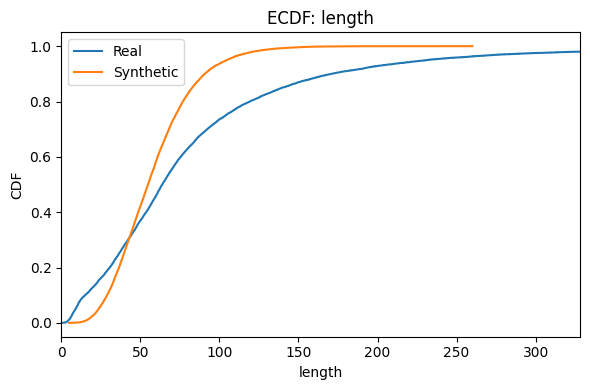

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# cap the tail to focus the comparison (e.g., 99th percentile)
cap = np.quantile(
    np.r_[edges_df['length'].values, synthetic_df['length'].values], 0.99
)
bins = np.linspace(0, cap, 60)  # SAME bins for both

plt.figure(figsize=(6,4))
plt.hist(edges_df['length'], bins=bins, density=True, alpha=0.6, label='Real')
plt.hist(synthetic_df['length'], bins=bins, density=True, alpha=0.6, label='Synthetic')
plt.xlim(0, cap)
plt.xlabel('length'); plt.ylabel('Density'); plt.title('Distribution of length')
plt.legend(); plt.tight_layout(); plt.show()

# ECDF overlay
def ecdf(x):
    x = np.sort(x); y = np.arange(1, len(x)+1)/len(x); return x, y
x_r, y_r = ecdf(edges_df['length']); x_s, y_s = ecdf(synthetic_df['length'])
plt.figure(figsize=(6,4))
plt.plot(x_r, y_r, label='Real'); plt.plot(x_s, y_s, label='Synthetic')
plt.xlim(0, cap); plt.xlabel('length'); plt.ylabel('CDF'); plt.title('ECDF: length')
plt.legend(); plt.tight_layout(); plt.show()


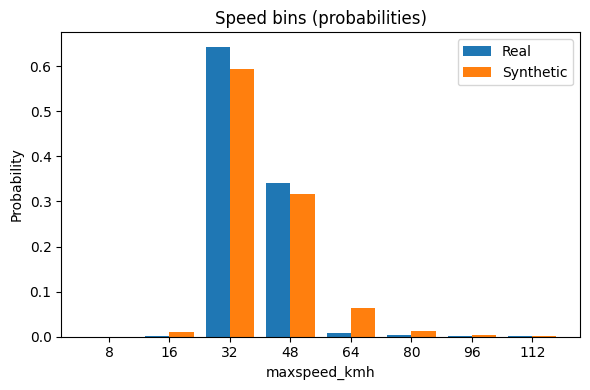

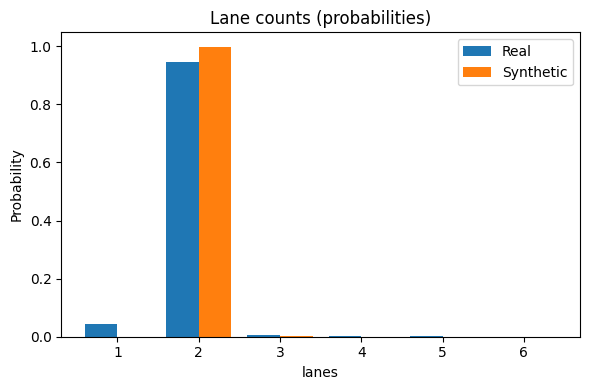

In [ ]:
# Speed and lane histogram
import numpy as np
import matplotlib.pyplot as plt

def plot_prob_bar(col, title=None):
    r = edges_df[col].astype(int).value_counts(normalize=True).sort_index()
    s = synthetic_df[col].astype(int).value_counts(normalize=True).sort_index()
    cats = sorted(set(r.index).union(s.index))
    r = r.reindex(cats, fill_value=0.0)
    s = s.reindex(cats, fill_value=0.0)

    x = np.arange(len(cats)); w = 0.4
    plt.figure(figsize=(6,4))
    plt.bar(x - w/2, r.values, width=w, label='Real')
    plt.bar(x + w/2, s.values, width=w, label='Synthetic')
    plt.xticks(x, cats)
    plt.ylabel('Probability'); plt.xlabel(col)
    plt.title(title or f'Distribution of {col}')
    plt.legend(); plt.tight_layout(); plt.show()

plot_prob_bar('maxspeed_kmh', 'Speed bins (probabilities)')
plot_prob_bar('lanes', 'Lane counts (probabilities)')


In [ ]:
import numpy as np

# real vs synthetic
real = edges_df
fake = synthetic_df

cont_cols = ['length', 'maxspeed_kmh', 'lanes']
stats = ['mean','std','q10','q25','q50','q75','q90']

errors = {col: {} for col in cont_cols}

for col in cont_cols:
    # compute real stats
    vals_r = real[col]
    stats_r = {
        'mean': vals_r.mean(),
        'std':  vals_r.std(),
        'q10':  vals_r.quantile(0.10),
        'q25':  vals_r.quantile(0.25),
        'q50':  vals_r.quantile(0.50),
        'q75':  vals_r.quantile(0.75),
        'q90':  vals_r.quantile(0.90),
    }
    # compute fake stats
    vals_f = fake[col]
    stats_f = {
        name: (vals_f.mean() if name=='mean'
               else vals_f.std() if name=='std'
               else vals_f.quantile(float(name[1:])/100))
        for name in stats
    }
    # compute RMSE and MAE over that vector
    diffs = np.array([stats_r[s] - stats_f[s] for s in stats])
    rmse = np.sqrt((diffs**2).mean())
    mae  = np.abs(diffs).mean()
    errors[col]['RMSE'] = rmse
    errors[col]['MAE']  = mae

# Print
for col in cont_cols:
    print(f"{col:15s}  RMSE: {errors[col]['RMSE']:.4f}  MAE: {errors[col]['MAE']:.4f}")


length           RMSE: 45.0954  MAE: 34.5919
maxspeed_kmh     RMSE: 1.0740  MAE: 0.7102
lanes            RMSE: 0.0907  MAE: 0.0378


# GraphRNN Model

## Model training

Mounted at /content/drive
Full graph: 9972 nodes, 11795 edges
Collected 20 spatial subgraphs
Saved subgraphs to /content/roadgraph_subgraphs_spatial.dat


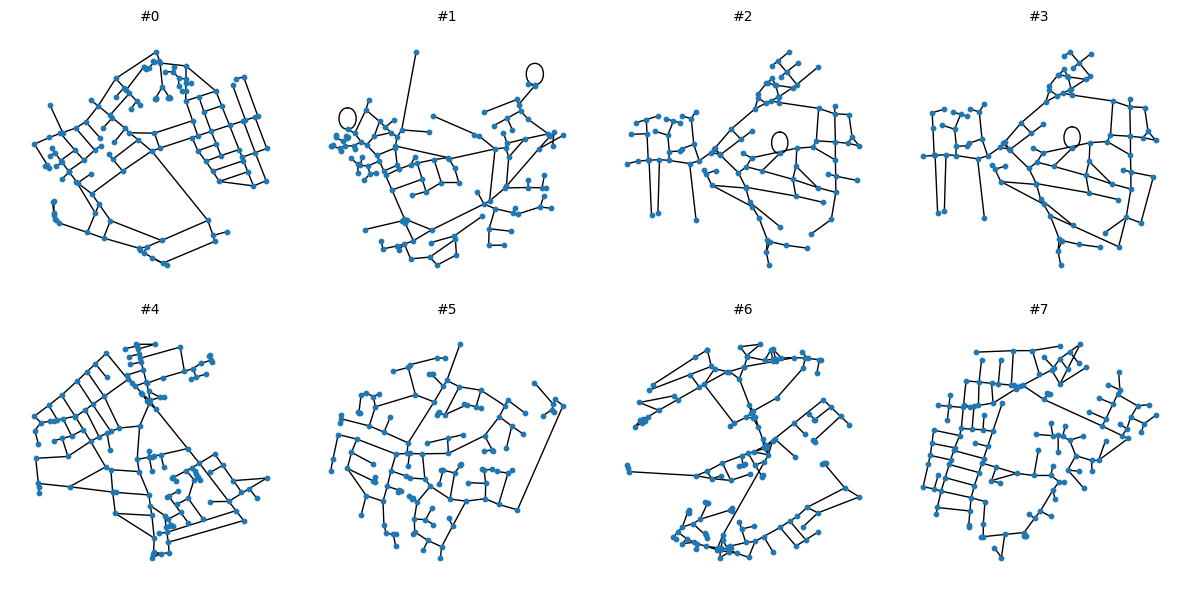

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import networkx as nx
import random
import pickle
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import numpy as np

# ─── 1) Load nodes and edges ───────────────────────────────────────────────
nodes_df = pd.read_csv('/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport/nodes_processed.csv')
edges_df = pd.read_csv('/content/drive/MyDrive/Ruian_ERP/road_networks/Stockport/edges_processed.csv')

# ─── 2) Build coordinate map and KDTree ─────────────────────────────────────
coords_dict = nodes_df.set_index('node_idx')[['x', 'y']].to_dict('index')
node_indices = list(coords_dict.keys())
points = [list(coords_dict[nid].values()) for nid in node_indices]
kdtree = KDTree(points)

# ─── 3) Build full NetworkX graph ───────────────────────────────────────────
G_full = nx.Graph()
for _, row in edges_df.iterrows():
    G_full.add_edge(int(row['u_idx']), int(row['v_idx']))

print(f"Full graph: {G_full.number_of_nodes()} nodes, {G_full.number_of_edges()} edges")

# ─── 4) Parameters ──────────────────────────────────────────────────────────
radius = 500          # spatial sampling radius in metres
desired = 40          # number of subgraphs to collect
min_nodes = 100       # skip tiny subgraphs
random.seed(42)
np.random.seed(42)

# ─── 5) Sampling loop ───────────────────────────────────────────────────────
subgraphs = []
original_node_maps = []  # list of dicts: old_id -> new_id
attempts = 0
max_attempts = 1000

while len(subgraphs) < desired and attempts < max_attempts:
    center_idx = random.choice(node_indices)
    center_xy = list(coords_dict[center_idx].values())

    nearby_idxs = kdtree.query_ball_point(center_xy, r=radius)
    sampled_nodes = [node_indices[i] for i in nearby_idxs]

    if len(sampled_nodes) < min_nodes:
        attempts += 1
        continue

    sg = G_full.subgraph(sampled_nodes).copy()
    if not nx.is_connected(sg):
        attempts += 1
        continue

    # Relabel to 0..n-1 and save both graph and mapping
    mapping = {old: i for i, old in enumerate(sg.nodes())}
    sg_relabelled = nx.relabel_nodes(sg, mapping)
    subgraphs.append(sg_relabelled)
    original_node_maps.append(mapping)
    attempts += 1

print(f"Collected {len(subgraphs)} spatial subgraphs")

# ─── 6) Save to disk ────────────────────────────────────────────────────────
with open('/content/roadgraph_subgraphs_spatial.dat', 'wb') as f:
    pickle.dump(subgraphs, f)
print("Saved subgraphs to /content/roadgraph_subgraphs_spatial.dat")

# ─── 7) Visualise a few with REAL GEOMETRY ──────────────────────────────────
plt.figure(figsize=(12, 6))
for i, sg in enumerate(subgraphs[:8]):
    plt.subplot(2, 4, i + 1)
    # Recover original coordinates for nodes
    mapping = original_node_maps[i]
    reverse_map = {v: k for k, v in mapping.items()}
    pos = {
        node: (coords_dict[reverse_map[node]]['x'], coords_dict[reverse_map[node]]['y'])
        for node in sg.nodes()
    }
    nx.draw(sg, pos=pos, node_size=10, with_labels=False)
    plt.title(f"#{i}", fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
import sys

# Add a custom path to import modules from another folder
sys.path.append('/content/drive/MyDrive/Ruian_ERP/road_networks/GraphRNN')

# Print all arguments passed to the script
print(sys.argv)


['/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py', '-f', '/root/.local/share/jupyter/runtime/kernel-374bb092-f76e-491d-a696-6702d8d8f49e.json']


In [ ]:
# training

# main.py
import os
import random
import shutil
import pickle
from random import shuffle
import numpy as np
import torch
import networkx as nx

# Patch NetworkX legacy calls if necessary
if not hasattr(nx, 'to_numpy_matrix'):
    nx.to_numpy_matrix   = nx.to_numpy_array
if not hasattr(nx, 'from_numpy_matrix'):
    nx.from_numpy_matrix = nx.from_numpy_array

from args import Args
from train import train, train_graph_completion, train_nll
from utils import save_graph_list
from data import (
    Graph_sequence_sampler_pytorch,            # <-- BFS variant
    Graph_sequence_sampler_pytorch_nobfs,
    Graph_sequence_sampler_pytorch_canonical
)

if __name__ == '__main__':
    # 1) Load arguments and force a BFS run label
    args = Args()
    os.environ['CUDA_VISIBLE_DEVICES'] = str(args.cuda)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if 'GraphRNN_RNN' not in args.note and 'GraphRNN_MLP' not in args.note:
        args.note = 'GraphRNN_RNN_bfs'
    else:
        # strip any accidental 'nobfs' token
        args.note = args.note.replace('nobfs', 'bfs')
    print('CUDA', args.cuda)
    print('File name prefix', args.fname)
    print('Run note:', args.note)

    # 2) Ensure output dirs exist
    for d in [args.model_save_path,
              args.graph_save_path,
              args.figure_save_path,
              args.timing_save_path,
              args.figure_prediction_save_path,
              args.nll_save_path]:
        os.makedirs(d, exist_ok=True)

    # 3) (Optional) clean tensorboard logs
    if args.clean_tensorboard and os.path.isdir("tensorboard"):
        shutil.rmtree("tensorboard")

    # 4) Load graph dataset (connected spatial subgraphs)
    print("Loading custom graph list from '/content/roadgraph_subgraphs_spatial.dat'...")
    with open('/content/roadgraph_subgraphs_spatial.dat', 'rb') as f:
        graphs = pickle.load(f)
    print(f"Loaded {len(graphs)} graphs.")

    # 5) Split into train/validate/test
    random.seed(123)
    shuffle(graphs)
    n = len(graphs)
    split_train = int(0.8 * n)
    split_val   = int(0.2 * n)
    graphs_train    = graphs[:split_train]
    graphs_test     = graphs[split_train:]
    graphs_validate = graphs[:split_val]

    # 6) Dataset stats
    avg_val_nodes  = np.mean([G.number_of_nodes() for G in graphs_validate])
    avg_test_nodes = np.mean([G.number_of_nodes() for G in graphs_test])
    print(f'Average nodes (validate): {avg_val_nodes:.1f}')
    print(f'Average nodes (test):     {avg_test_nodes:.1f}')

    args.max_num_node = max(G.number_of_nodes() for G in graphs)
    max_edges = max(G.number_of_edges() for G in graphs)
    min_edges = min(G.number_of_edges() for G in graphs)
    print(f"Total graphs: {n}, train: {len(graphs_train)}")
    print(f"Max nodes: {args.max_num_node}")
    print(f"Max/min edges: {max_edges}, {min_edges}")

    # Let the BFS dataset compute max_prev_node from data
    args.max_prev_node = None
    print(f"(Before dataset) max_prev_node: {args.max_prev_node}")

    # 7) Save ground-truth snapshots if needed
    save_graph_list(graphs_train, args.graph_save_path + args.fname_train + '0.dat')
    save_graph_list(graphs_test,  args.graph_save_path + args.fname_test  + '0.dat')
    print("Train/test graphs saved.")

    # 8) Initialise BFS dataset (default branch)
    if 'nobfs' in args.note:
        raise RuntimeError("This run should be BFS. Remove 'nobfs' from args.note.")
    elif 'barabasi_noise' in args.graph_type:
        dataset = Graph_sequence_sampler_pytorch_canonical(
            graphs_train,
            max_prev_node=args.max_prev_node
        )
        # fall back if canonical path sets it
        args.max_prev_node = dataset.max_prev_node if hasattr(dataset, 'max_prev_node') else args.max_num_node - 1
    else:
        dataset = Graph_sequence_sampler_pytorch(
            graphs_train,
            max_prev_node=args.max_prev_node,   # None → dataset estimates from data
            max_num_node=args.max_num_node
        )
        args.max_prev_node = dataset.max_prev_node  # <-- use BFS-estimated value

    print(f"(After dataset) max_prev_node (BFS-estimated): {args.max_prev_node}")

    sampler = torch.utils.data.sampler.WeightedRandomSampler(
        weights=[1.0/len(dataset)] * len(dataset),
        num_samples=args.batch_size * args.batch_ratio,
        replacement=True
    )
    dataset_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=args.batch_size,
        num_workers=args.num_workers,
        sampler=sampler
    )

    # 9) Initialise model per args.note (keep as-is)
    if 'GraphRNN_VAE_conditional' in args.note:
        from model import GRU_plain, MLP_VAE_conditional_plain
        rnn = GRU_plain(
            input_size=args.max_prev_node,
            embedding_size=args.embedding_size_rnn,
            hidden_size=args.hidden_size_rnn,
            num_layers=args.num_layers,
            has_input=True,
            has_output=False
        ).to(device)
        output = MLP_VAE_conditional_plain(
            h_size=args.hidden_size_rnn,
            embedding_size=args.embedding_size_output,
            y_size=args.max_prev_node
        ).to(device)

    elif 'GraphRNN_MLP' in args.note:
        from model import GRU_plain, MLP_plain
        rnn = GRU_plain(
            input_size=args.max_prev_node,
            embedding_size=args.embedding_size_rnn,
            hidden_size=args.hidden_size_rnn,
            num_layers=args.num_layers,
            has_input=True,
            has_output=False
        ).to(device)
        output = MLP_plain(
            h_size=args.hidden_size_rnn,
            embedding_size=args.embedding_size_output,
            y_size=args.max_prev_node
        ).to(device)

    elif 'GraphRNN_RNN' in args.note:
        from model import GRU_plain
        rnn = GRU_plain(
            input_size=args.max_prev_node,
            embedding_size=args.embedding_size_rnn,
            hidden_size=args.hidden_size_rnn,
            num_layers=args.num_layers,
            has_input=True,
            has_output=True,
            output_size=args.hidden_size_rnn_output
        ).to(device)
        output = GRU_plain(
            input_size=1,
            embedding_size=args.embedding_size_rnn_output,
            hidden_size=args.hidden_size_rnn_output,
            num_layers=args.num_layers,
            has_input=True,
            has_output=True,
            output_size=1
        ).to(device)
    else:
        raise ValueError(f"Unknown model type in note: {args.note}")

    args.epochs = 200

    # 10) Train
    train(args, dataset_loader, rnn, output)


CUDA 1
File name prefix GraphRNN_RNN_grid_4_128_
Run note: GraphRNN_RNN
Loading custom graph list from '/content/roadgraph_subgraphs_spatial.dat'...
Loaded 20 graphs.
Average nodes (validate): 120.5
Average nodes (test):     122.5
Total graphs: 20, train: 16
Max nodes: 156
Max/min edges: 190, 108
(Before dataset) max_prev_node: None
Train/test graphs saved.
calculating max previous node, total iteration: 20000
iter 0 times
iter 4000 times
iter 8000 times
iter 12000 times
iter 16000 times
max previous node: 34
(After dataset) max_prev_node (BFS-estimated): 34


/content/drive/MyDrive/Ruian_ERP/road_networks/GraphRNN/model.py:299: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(param,gain=nn.init.calculate_gain('sigmoid'))
/content/drive/MyDrive/Ruian_ERP/road_networks/GraphRNN/model.py:297: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(param, 0.25)
/content/drive/MyDrive/Ruian_ERP/road_networks/GraphRNN/model.py:302: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  m.weight.data = init.xavier_uniform(m.weight.data, gain=nn.init.calculate_gain('relu'))


Streaming output truncated to the last 5000 lines.
Epoch 44 | Batch 29 | Loss: 0.0544
Epoch 44 | Batch 30 | Loss: 0.0537
Epoch 44 | Batch 31 | Loss: 0.0558
Epoch 45 | Batch 0 | Loss: 0.0550
Epoch 45 | Batch 1 | Loss: 0.0593
Epoch 45 | Batch 2 | Loss: 0.0557
Epoch 45 | Batch 3 | Loss: 0.0539
Epoch 45 | Batch 4 | Loss: 0.0528
Epoch 45 | Batch 5 | Loss: 0.0549
Epoch 45 | Batch 6 | Loss: 0.0534
Epoch 45 | Batch 7 | Loss: 0.0551
Epoch 45 | Batch 8 | Loss: 0.0539
Epoch 45 | Batch 9 | Loss: 0.0575
Epoch 45 | Batch 10 | Loss: 0.0537
Epoch 45 | Batch 11 | Loss: 0.0507
Epoch 45 | Batch 12 | Loss: 0.0500
Epoch 45 | Batch 13 | Loss: 0.0549
Epoch 45 | Batch 14 | Loss: 0.0537
Epoch 45 | Batch 15 | Loss: 0.0512
Epoch 45 | Batch 16 | Loss: 0.0545
Epoch 45 | Batch 17 | Loss: 0.0557
Epoch 45 | Batch 18 | Loss: 0.0514
Epoch 45 | Batch 19 | Loss: 0.0529
Epoch 45 | Batch 20 | Loss: 0.0555
Epoch 45 | Batch 21 | Loss: 0.0550
Epoch 45 | Batch 22 | Loss: 0.0549
Epoch 45 | Batch 23 | Loss: 0.0552
Epoch 45 | Bat

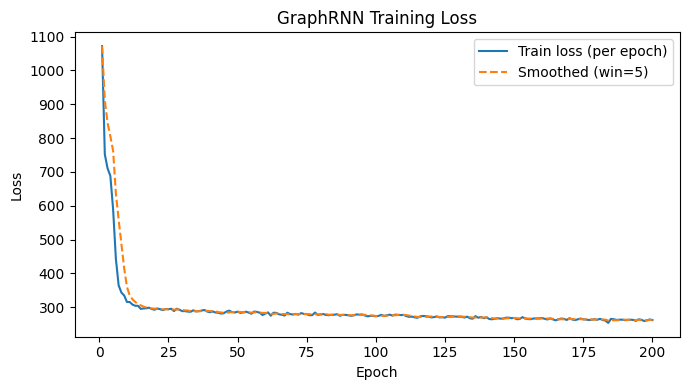

Saved figure to: ./figures/GraphRNN_RNN_grid_4_128_train_loss_curve.png


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Path to the CSV just saved by training
CSV = "./figures/GraphRNN_RNN_grid_4_128_train_loss.csv"
assert os.path.exists(CSV), f"Not found: {CSV}"

# Read CSV
df = pd.read_csv(CSV)

# Optional smoothing for a cleaner curve
df["loss_smooth"] = df["loss"].rolling(window=5, min_periods=1).mean()

# Plot
plt.figure(figsize=(7, 4))
plt.plot(df["epoch"], df["loss"], label="Train loss (per epoch)")
plt.plot(df["epoch"], df["loss_smooth"], linestyle="--", label="Smoothed (win=5)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GraphRNN Training Loss")
plt.legend()
plt.tight_layout()

# Save figure
out_png = "./figures/GraphRNN_RNN_grid_4_128_train_loss_curve.png"
plt.savefig(out_png, dpi=200)
plt.show()

print("Saved figure to:", out_png)


## Metrics evaluation

[Dir] /content/graphs
[Real] /content/graphs/GraphRNN_RNN_grid_4_128_train_0.dat
[List] first 12 files: ['GraphRNN_RNN_grid_4_128_pred_100_1.dat', 'GraphRNN_RNN_grid_4_128_pred_200_1.dat', 'GraphRNN_RNN_grid_4_128_test_0.dat', 'GraphRNN_RNN_grid_4_128_train_0.dat']
[Load] Real graphs: 16
[Gen] /content/graphs/GraphRNN_RNN_grid_4_128_pred_200_1.dat
[Load] Generated graphs: 1024
[Degree] KS D=0.1365 (p=2.01e-30) | W1=0.1983


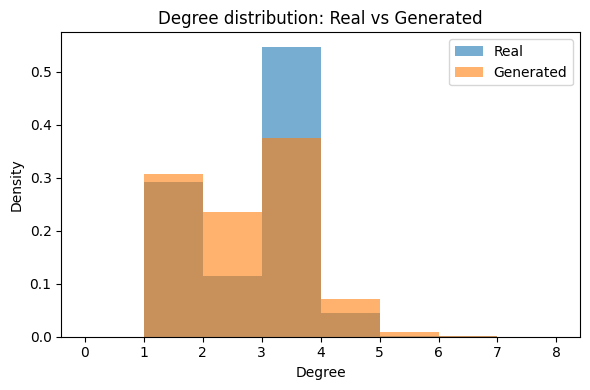

[LCC share] Real=1.000 | Gen=0.857
[Avg shortest path (LCC)] Real=9.855 | Gen=9.490


In [ ]:
import os, glob, pickle, numpy as np, networkx as nx, matplotlib.pyplot as plt
from scipy.stats import ks_2samp, wasserstein_distance

# --- resolve paths fast (no recursion) ---
from args import Args
a = Args()
graphs_dir = os.path.abspath(a.graph_save_path)  # e.g. ./graphs/ → /content/…/graphs
real_path  = os.path.join(graphs_dir, a.fname_train + '0.dat')  # e.g. GraphRNN_RNN_grid_4_128_train_0.dat
print("[Dir]", graphs_dir)
print("[Real]", real_path)

if not os.path.isdir(graphs_dir):
    raise FileNotFoundError(f"Graph save dir not found: {graphs_dir}")

# List a few files to sanity-check
files = sorted(os.listdir(graphs_dir))
print("[List] first 12 files:", files[:12])

# Load real graphs (train snapshot 0)
if not os.path.exists(real_path):
    raise FileNotFoundError(f"Real graph list not found: {real_path}\nFiles here: {files[:20]}")

with open(real_path, 'rb') as f:
    real_graphs = pickle.load(f)
print(f"[Load] Real graphs: {len(real_graphs)}")

# Find generated graphs (non-recursive; prefer *_pred_*.dat)
pred_candidates = sorted(glob.glob(os.path.join(graphs_dir, "*_pred_*.dat")))
if not pred_candidates:
    # Some repos save with fname_pred prefix; try that if available
    fname_pred = getattr(a, "fname_pred", a.fname_train.replace("train", "pred"))
    pred_candidates = sorted(glob.glob(os.path.join(graphs_dir, fname_pred + "*.dat")))
if not pred_candidates:
    raise FileNotFoundError(f"No generated graph list found in {graphs_dir} (pattern '*_pred_*.dat').\n"
                            f"Files: {files[:20]}")

gen_path = pred_candidates[-1]
print("[Gen]", gen_path)

with open(gen_path, 'rb') as f:
    gen_graphs = pickle.load(f)
print(f"[Load] Generated graphs: {len(gen_graphs)}")

# --- helpers ---
def degree_array(Gs):
    arr = []
    for G in Gs:
        if G.number_of_nodes() > 0:
            arr.append(np.fromiter((d for _, d in G.degree()), dtype=int))
    return np.concatenate(arr) if arr else np.array([], dtype=int)

def lcc_share(G):
    if G.number_of_nodes() == 0:
        return 0.0
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    return len(comps[0]) / G.number_of_nodes()

def avg_shortest_path_lcc(G):
    if G.number_of_nodes() < 2:
        return np.nan
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    H = G.subgraph(comps[0]).copy()
    return np.nan if H.number_of_nodes() < 2 else nx.average_shortest_path_length(H)

# --- metrics ---
deg_real = degree_array(real_graphs)
deg_gen  = degree_array(gen_graphs)
if deg_real.size == 0 or deg_gen.size == 0:
    raise RuntimeError("Empty degree arrays – check the loaded graph lists.")

ks_d, ks_p = ks_2samp(deg_real, deg_gen)
w1_deg = wasserstein_distance(deg_real, deg_gen)
print(f"[Degree] KS D={ks_d:.4f} (p={ks_p:.3g}) | W1={w1_deg:.4f}")

plt.figure(figsize=(6,4))
bins = range(0, int(max(deg_real.max(), deg_gen.max())) + 1)
plt.hist(deg_real, bins=bins, alpha=0.6, label='Real', density=True)
plt.hist(deg_gen,  bins=bins, alpha=0.6, label='Generated', density=True)
plt.xlabel('Degree'); plt.ylabel('Density'); plt.title('Degree distribution: Real vs Generated')
plt.legend(); plt.tight_layout(); plt.show()

lcc_r = float(np.mean([lcc_share(G) for G in real_graphs]))
lcc_g = float(np.mean([lcc_share(G) for G in gen_graphs]))
asp_r = float(np.nanmean([avg_shortest_path_lcc(G) for G in real_graphs]))
asp_g = float(np.nanmean([avg_shortest_path_lcc(G) for G in gen_graphs]))
print(f"[LCC share] Real={lcc_r:.3f} | Gen={lcc_g:.3f}")
print(f"[Avg shortest path (LCC)] Real={asp_r:.3f} | Gen={asp_g:.3f}")
